In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
train = pd.read_csv("./input/train.csv"); #Load training dataset from the input directory

In [3]:
test = pd.read_csv("./input/test.csv"); #Load test dataset from the input directory

In [4]:
label = train.label
train = train.drop(train.columns[0],axis=1) #copy the label column and remove it from train variable
#This is done to seperate the labels from features.
#The features should be in seprate variable for training.

In [7]:
train.head(2);

(42000,)
(42000, 784)


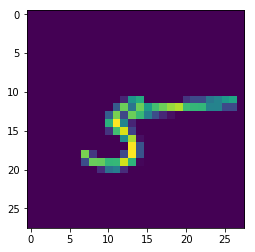

In [8]:
#Have Validation set to validate the train results at each iteration
#mapping training and validation data to X and y variables as numpy object.
X_train = train[:-5000];
y_train = label[:-5000];
X_train = train.as_matrix().astype(np.float32);
y_train = label.as_matrix().astype(np.float32);
X_valid = train.iloc[-5000:].as_matrix().astype(np.float32)
y_valid = label.iloc[-5000:].as_matrix().astype(np.float32)
print (y_train.shape)
print (X_train.shape)
plt.imshow(X_valid[1].reshape(28,28))
plt.show()

In [9]:
#mapping y labels to vector of size 10(labels)
#example y = 2 ==> y = [0,0,1,0,0,0,0,0,0,0] for training the classification model
num_labels = 10
X_test = test.as_matrix().astype(np.float32)
X_valid = X_valid.astype(np.float32)
y_valid = y_valid.astype(np.float32)
y_train = (np.arange(num_labels) == y_train[:,None]).astype(np.float32)
y_valid = (np.arange(num_labels) == y_valid[:,None]).astype(np.float32)
print(X_train.dtype,y_train.dtype,X_valid.dtype)

float32 float32 float32


In [14]:
image_size = 28
num_labels = 10
num_steps = 12000
batch_size = 100
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def initNN():
    Weight = tf.Variable(tf.truncated_normal([5,5,1,32]))
    Weight1 = tf.Variable(tf.truncated_normal([5,5,32,64]))
    Weight2 = tf.Variable(tf.truncated_normal([7*7*64,1024]))
    Weight3 = tf.Variable(tf.truncated_normal([1024,num_labels]))
    bias = tf.Variable(tf.zeros([32]))
    bias1 = tf.Variable(tf.zeros([64]))
    bias2 = tf.Variable(tf.zeros([1024]))
    bias3 = tf.Variable(tf.zeros([num_labels]))
    return [Weight,bias,Weight1,bias1,Weight2,bias2,Weight3,bias3]

def forwardCNN(X,W):
    X = tf.reshape(X,[-1,28,28,1])
    
    H1 = conv2d(X,W[0])+W[1];
    H1 = tf.nn.relu(H1);
    H2 = max_pool_2x2(H1);
    
    H2 = conv2d(H2,W[2])+W[3];
    H2 = tf.nn.relu(H2);
    H3 = max_pool_2x2(H2);
    
    H3 = tf.reshape(H3, [-1, 7*7*64])
    H3 = tf.matmul(H3,W[4])+W[5];
    H3 = tf.nn.relu(H3);
    
    H3 = tf.nn.dropout(H3,0.6)
    
    H4 = tf.matmul(H3,W[6])+W[7];
    return H4

graph = tf.Graph()
with graph.as_default():
    X = tf.placeholder(tf.float32,[None,784])
    y = tf.placeholder(tf.float32,[None,num_labels])
    W = initNN()
    H2 = forwardCNN(X,W)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(H2,y))
    optimizer = tf.train.AdamOptimizer(1e-2).minimize(loss)
    train_prediction = (H2)
    valid_prediction = (forwardCNN(X_valid,W))
    test = tf.nn.softmax(H2)

In [15]:
def accuracy(predictions, labels):
    eq = (np.argmax(predictions, 1) == np.argmax(labels, 1))
    return ((100.0 * np.sum(eq))/eq.size)
Result = [];
sess = {};
with tf.Session(graph=graph) as session:
    sess = session;
    tf.global_variables_initializer().run()
    offset=0
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (X_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict = {X : batch_data, y : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction],feed_dict=feed_dict)
        if (step % 2000 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("mini batch accuracy: ", accuracy(predictions, batch_labels))            
            print("Validation accuracy: ", accuracy(valid_prediction.eval(), y_valid))        
    count = 0;
    result = [];
    for i in range(int(X_test.shape[0]/100)):
        result.extend(np.argmax(session.run([test],feed_dict={X:X_test[count:count+100]})[0],1))
        count = count+100;
    print("done")

Initialized
Minibatch loss at step 0: 17756464.000000
mini batch accuracy:  8.0
Validation accuracy:  16.38
Minibatch loss at step 2000: 2603.605469
mini batch accuracy:  99.0
Validation accuracy:  97.08
Minibatch loss at step 4000: 0.000000
mini batch accuracy:  100.0
Validation accuracy:  98.44
Minibatch loss at step 6000: 4209.136719
mini batch accuracy:  97.0
Validation accuracy:  99.02
Minibatch loss at step 8000: 1190.541260
mini batch accuracy:  99.0
Validation accuracy:  98.92
Minibatch loss at step 10000: 518.546997
mini batch accuracy:  99.0
Validation accuracy:  98.18
done


In [16]:
print(len(result))

28000


In [18]:
test_label = pd.DataFrame(data=result,columns=['Label']);
test_label.to_csv(path_or_buf=open('test_result.csv','w'),index=False)

In [19]:
test_label.tail(10)

,Label
27990,7
27991,6
27992,1
27993,9
27994,7
27995,9
27996,7
27997,3
27998,9
27999,2
